In [ ]:
!pip install mesa==3.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 2.3 MB/s eta 0:00:00


<ipython-input-22-3712b1393cf6>:237: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)
/usr/local/lib/python3.11/dist-packages/mesa/agent.py:69: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100


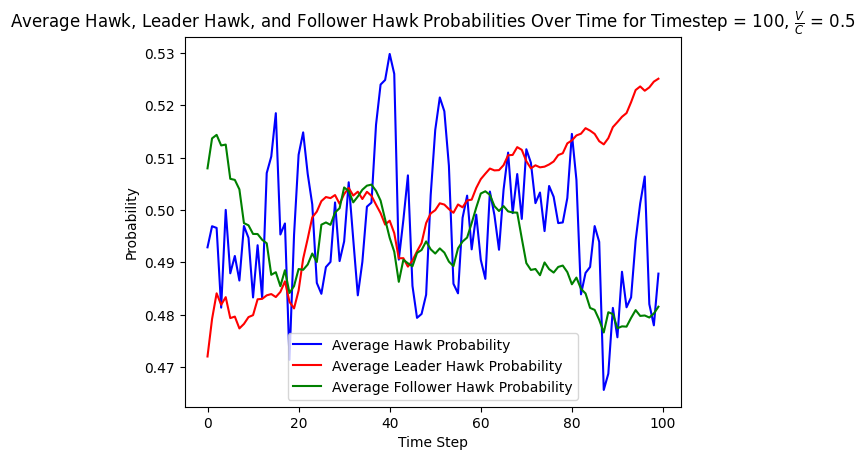

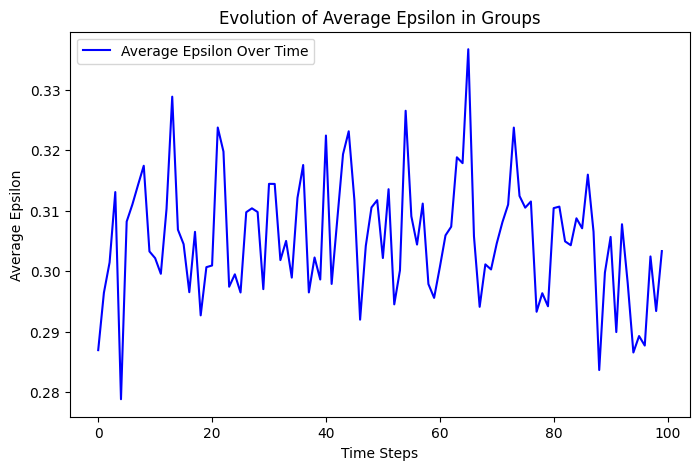

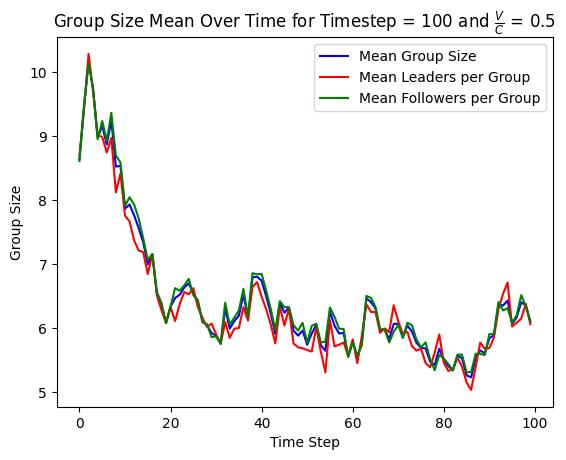

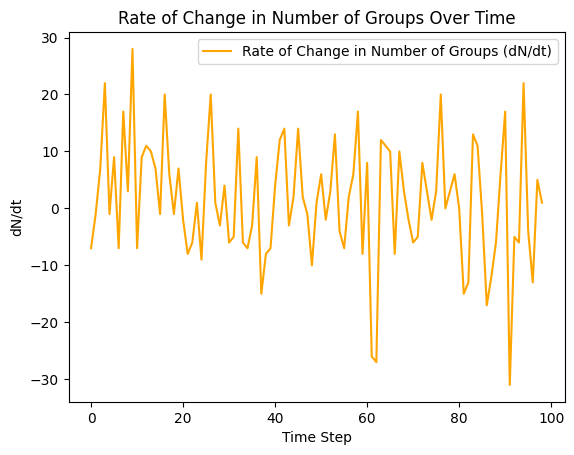

<ipython-input-22-3712b1393cf6>:603: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapl = cm.get_cmap('rainbow')
<ipython-input-22-3712b1393cf6>:606: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmapf = cm.get_cmap('rainbow')


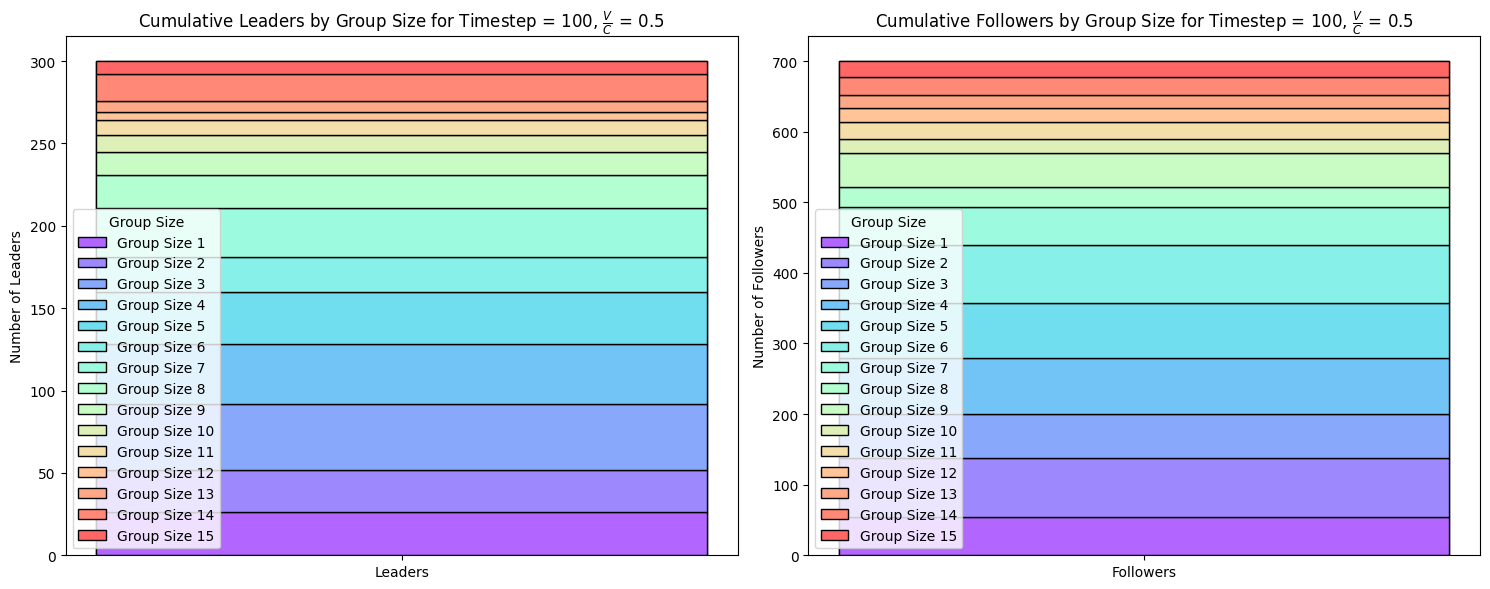

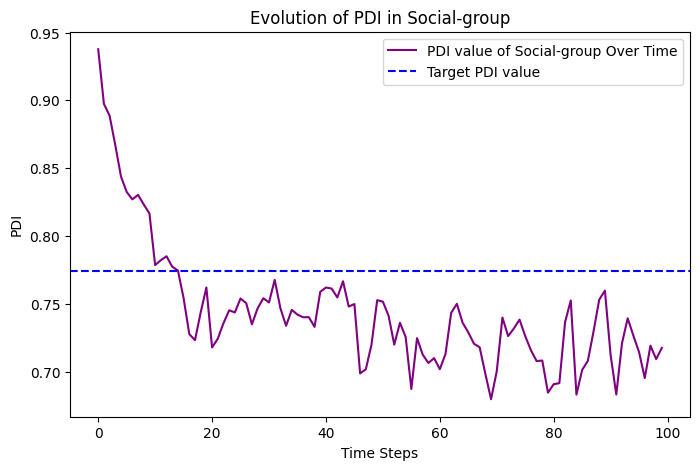

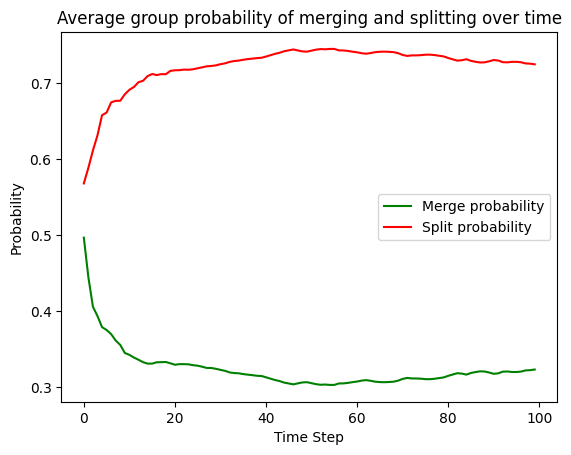

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.colors as mcolors

class IndividualAgent(Agent):
    def __init__(self, unique_id, model, group_id, role, dv, dc, V, C):
        super().__init__(model)
        self.group_id = group_id
        self.role = role  # 'leader' or 'follower'
        self.leader_hawk_prob = random.uniform(0, 1) if role == 'leader' else None
        self.follower_hawk_prob = random.uniform(0, 1) if role == 'follower' else None
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C
        self.fisfus_prob = random.uniform(0, 1)

class Group:
    def __init__(self, group_id, agents, model, omega, dv, dc, V, C):
        self.group_id = group_id
        self.agents = agents
        self.model = model
        self.hawk_prob = self.calculate_hawk_prob()
        self.strategy = self.determine_strategy()
        self.payoff = 0  # Initialize payoff
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C
        self.merge_prob = random.uniform(0, 1)
        self.split_prob = random.uniform(0, 1)


    def calculate_hawk_prob(self):
        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")

        # Calculate average follower and leader probability of playing Hawk
        leader_hawk_prob_avg = (
            sum(agent.leader_hawk_prob for agent in self.agents if agent.role == 'leader') / num_leader
            if num_leader > 0 else 0
        )
        follower_hawk_prob_avg = (
            sum(agent.follower_hawk_prob for agent in self.agents if agent.role == 'follower') / num_follower
            if num_follower > 0 else 0
        )

        # Calculate alpha
        epsilon = num_leader / (num_leader + num_follower)
        alpha = epsilon / (epsilon + self.model.omega * (1 - epsilon))

        # Recalculate the overall Hawk probability as a weighted average of leader and follower probabilities
        hawk_prob = (alpha * leader_hawk_prob_avg +
                          (1 - alpha) * follower_hawk_prob_avg)
        return hawk_prob

    def determine_strategy(self):
        return 'Hawk' if self.model.random.random() < self.hawk_prob else 'Dove'

    def calculate_payoff(self, neighbors):
        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")
        n = num_leader + num_follower
        epsilon = num_leader / (n)

        # Calculate value and cost values for leaders and followers
        CL = (C * (1 - dc)) / ((n * dc) * (1 - epsilon) + (n * epsilon) * (1 - dc))
        CF = (C * dc) / ((n * dc) * (1 - epsilon) + (n * epsilon) * (1 - dc))
        VL = (V * dv) / ((n * epsilon * dv) + (n * (1 - dv) * (1 - epsilon)))
        VF = (V * (1 - dv)) / ((n * epsilon * dv) + (n * (1 - dv) * (1 - epsilon)))

        # Count the number of agents in neighbors who played Hawk and Dove
        hawk_count = sum(1 for neighbor in neighbors if neighbor.strategy == 'Hawk')
        dove_count = sum(1 for neighbor in neighbors if neighbor.strategy == 'Dove')
        total_agents = len(neighbors)

        # Avoid division by zero in empirical_hawk_prob calculation
        empirical_hawk_prob = hawk_count / total_agents if total_agents > 0 else 0

        # Calculate payoffs for the group based on strategies
        if self.strategy == 'Hawk':
            overall_payoff = ((V - C) / 2) * hawk_count + V * dove_count
            leader_payoff = ((VL - CL) / 2) * hawk_count + VL * dove_count
            follower_payoff = ((VF - CF) / 2) * hawk_count + VF * dove_count
        else:
            overall_payoff = (V / 2) * dove_count
            leader_payoff = (VL / 2) * dove_count
            follower_payoff = (VF / 2) * dove_count

        # Assign the overall payoff to the group
        self.payoff = overall_payoff

        # Output the calculated payoffs
        return {
            'overall_payoff': overall_payoff,
            'leader_payoff': leader_payoff,
            'follower_payoff': follower_payoff,
            'empirical_hawk_prob': empirical_hawk_prob,
            'hawk_count': hawk_count
        }

    def step(self):
        # Find neighbors (other groups)
        neighbors = [agent for group in self.model.groups if group.group_id != self.group_id for agent in group.agents]

        # Calculate the group's payoff
        payoff_data = self.calculate_payoff(neighbors)

    def advance(self):
        total_leader_payoff = 0
        total_follower_payoff = 0
        total_payoff = 0
        hawk_count = 0
        num_other_groups = len(self.model.groups) - 1

        # Calculate number of leaders and followers in the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")

        # Calculate alpha
        epsilon = num_leader / (num_leader + num_follower)
        alpha = epsilon / (epsilon + self.model.omega * (1 - epsilon))

        # Loop through all other groups to calculate total payoffs
        for other_group in self.model.groups:
            if other_group != self:  # Exclude current group
                payoffs = other_group.calculate_payoff(self.model.groups)
                total_leader_payoff += payoffs['leader_payoff']
                total_follower_payoff += payoffs['follower_payoff']
                total_payoff += payoffs['overall_payoff']
                hawk_count += sum(1 for agent in other_group.agents if agent.role == 'leader' and other_group.strategy == 'Hawk')

        avg_leader_payoff = total_leader_payoff / (len(self.model.groups) - 1)
        avg_follower_payoff = total_follower_payoff / (len(self.model.groups) - 1)         # is this right?
        avg_payoff = total_payoff / (len(self.model.groups) - 1)

        # Calculate the current group's payoffs
        current_payoffs = self.calculate_payoff(self.model.groups)
        leader_payoff_diff = current_payoffs['leader_payoff'] - avg_leader_payoff
        follower_payoff_diff = current_payoffs['follower_payoff'] - avg_follower_payoff
        payoff_diff = current_payoffs['overall_payoff'] - avg_payoff
        empirical_hawk_prob = current_payoffs['empirical_hawk_prob']

        # Update individual probabilities
        learning_rate = 0.05
        # Update agent probabilities based on group's strategy
        for agent in self.agents:
            if self.strategy == 'Hawk':  # If group played Hawk, increase probability
                if agent.role == 'leader':
                    agent.leader_hawk_prob += learning_rate * alpha * leader_payoff_diff * abs(empirical_hawk_prob - agent.leader_hawk_prob) * (1 - agent.leader_hawk_prob)
                    agent.leader_hawk_prob = max(0, min(1, agent.leader_hawk_prob)) # Ensure probabilities stay in [0,1]
                elif agent.role == 'follower':
                    agent.follower_hawk_prob += learning_rate * (1 - alpha) * follower_payoff_diff * abs(empirical_hawk_prob - agent.follower_hawk_prob) * (1 - agent.follower_hawk_prob)
                    agent.follower_hawk_prob = max(0, min(1, agent.follower_hawk_prob)) # Ensure probabilities stay in [0,1]
            else:  # If group played Dove, decrease probability
                if agent.role == 'leader':
                    agent.leader_hawk_prob -= learning_rate * alpha * leader_payoff_diff * abs(empirical_hawk_prob - agent.leader_hawk_prob) * agent.leader_hawk_prob
                    agent.leader_hawk_prob = max(0, min(1, agent.leader_hawk_prob)) # Ensure probabilities stay in [0,1]
                elif agent.role == 'follower':
                    agent.follower_hawk_prob -= learning_rate * (1 - alpha) * follower_payoff_diff * abs(empirical_hawk_prob - agent.follower_hawk_prob) * agent.follower_hawk_prob
                    agent.follower_hawk_prob = max(0, min(1, agent.follower_hawk_prob)) # Ensure probabilities stay in [0,1]

        # # Recalculate the group's Hawk probability and strategy
        # group_size_counts = {}
        # self.hawk_prob = self.calculate_hawk_prob()
        # self.strategy = self.determine_strategy()
        # S_max = 15 # Maximum group size
        # S_sum = (S_max * (S_max + 1)) // 2 # Sum of group sizes up to S_max
        # S2_sum = (S_max * (S_max + 1) * (2 * S_max + 1)) // 6

        # PDI_target = (S_sum ** 2) / (S_max * S2_sum)

        # Adjusted PDI Calculation
        group_size_counts = {}
        S_max = 15  # Maximum group size
        p = 1.2  # Factor to bias towards smaller groups
        S_sum_p = sum(i**p for i in range(1, S_max + 1))  # Sum of sizes^p
        S2_sum_p = sum(i**(2*p) for i in range(1, S_max + 1))  # Sum of sizes^(2p)
        PDI_target = (S_sum_p ** 2) / (S_max * S2_sum_p)


        # Count number of members per group size
        for group in self.model.groups:
            size = len(group.agents)
            if size in group_size_counts:
                group_size_counts[size] += size
            else:
                group_size_counts[size] = size

        # Compute number average
        M_w = (sum((count * size) for size, count in group_size_counts.items()) /
              sum(count for size, count in group_size_counts.items()))

        # Compute weight average
        M_n = (sum((count * (size**2)) for size, count in group_size_counts.items()) /
              sum((count * size) for size, count in group_size_counts.items()))

        # Compute PolyDispersity Index
        PDI = (M_w / M_n)

        learning_rate = 0.05
        # Adjust merge_prob and split_prob based on PDI deviation
        self.split_prob += learning_rate * (PDI - PDI_target)
        self.merge_prob -= learning_rate * (PDI - PDI_target)

        # Ensure probabilities remain within [0,1]
        self.split_prob = max(0, min(1, self.split_prob))
        self.merge_prob = max(0, min(1, self.merge_prob))

    def get_epsilon(self):   # Method for calculating epsilon for the group
        num_leader = sum(1 for agent in self.agents if agent.role == "leader")
        num_follower = sum(1 for agent in self.agents if agent.role == "follower")
        return num_leader / (num_leader + num_follower) if (num_leader + num_follower) > 0 else 0


class GroupModel(Model):
    def __init__(self, N, num_groups, omega, dv, dc, V, C, time_steps):
        self.N = N
        self.num_groups = num_groups
        self.time_steps = time_steps
        self.omega = omega
        self.dv = dv
        self.dc = dc
        self.V = V
        self.C = C
        self.Vbar=V/C
        self.random = random.Random()
        self.schedule = SimultaneousActivation(self)
        self.groups = []
        self.hawk_prob_values = []  # To store average Hawk probabilities over time
        self.leader_hawk_prob_values = []  # To store leader Hawk probabilities over time
        self.follower_hawk_prob_values = []  # To store follower Hawk probabilities over time
        self.fisfus_prob_values = []  # To store average fisfus_prob over time
        self.leader_fisfus_prob_values = [] # To store average leader fisfus_prob over time
        self.merge_prob_values = [] # To store merge probability values
        self.split_prob_values = [] # To store split probability values
        self.median_group_size_values = []  # Store median group size over time
        self.mean_group_size_values = []    # Store mean group size over time
        self.mean_leaders_per_group_values = []
        self.mean_followers_per_group_values = []
        self.mode_group_size_values = []    # Store mode group size over time
        self.num_groups_history = []  # To store the number of groups at each time step
        self.average_epsilon_values = []  # List to store average epsilon per time step
        self.PDI_values = []  # List to store PDI values over time


        # Create agents and assign them to groups
        agents_per_group = N // num_groups


        for group_id in range(num_groups):
            agents = []

            # Create leaders
            for i in range(3):
                leader = IndividualAgent(group_id * agents_per_group + i, self, group_id, 'leader', dv, dc, V, C)
                agents.append(leader)

            # Create followers
            for i in range(3, agents_per_group):
                follower = IndividualAgent(group_id * agents_per_group + i, self, group_id, 'follower', dv, dc, V, C)
                agents.append(follower)

            group = Group(group_id, agents, self, omega=omega, dv=dv, dc=dc, V=V, C=C)
            self.groups.append(group)

            for agent in agents:
                self.schedule.add(agent)

    def step(self):
        # Call advance for all groups to update their state
        for group in self.groups:
            group.advance()


        # Handle group merging and splitting
        self.handle_group_merging_and_splitting()

        # Collect and store probabilities for plotting
        self.collect_probabilities()

        # Compute and store PDI for this timestep
        PDI = self.compute_PDI()
        self.PDI_values.append(PDI)  # Save PDI value for plotting


        # Track and collect average epsilon over all groups
        avg_epsilon = np.mean([group.get_epsilon() for group in self.groups])
        self.average_epsilon_values.append(avg_epsilon)

        # Advance the simulation's schedule
        self.schedule.step()

        # Track the number of groups at this time step
        self.num_groups_history.append(len(self.groups))

    def compute_PDI(self):
        group_size_counts = {}
        S_max = 15  # Maximum group size
        S_sum = (S_max * (S_max + 1)) // 2  # Sum of group sizes up to S_max
        S2_sum = (S_max * (S_max + 1) * (2 * S_max + 1)) // 6

        # Count number of members per group size
        for group in self.groups:
            size = len(group.agents)
            if size in group_size_counts:
                group_size_counts[size] += size
            else:
                group_size_counts[size] = size

        # Compute number average (Mn)
        M_n = (sum((count * (size**2)) for size, count in group_size_counts.items()) /
               sum((count * size) for size, count in group_size_counts.items()))

        # Compute weight average (Mw)
        M_w = (sum((count * size) for size, count in group_size_counts.items()) /
               sum(count for size, count in group_size_counts.items()))

        # Compute PolyDispersity Index (PDI)
        PDI = M_w / M_n
        return PDI

    def handle_group_merging_and_splitting(self):
        if len(self.groups) > 1:
            merged_groups = set()

            # Compute current size distribution
            size_counts = {size: sum(1 for g in self.groups if len(g.agents) == size) for size in range(1, 16)}

            for group in self.groups[:]:  # Copy for safe iteration
                if group in merged_groups:
                    continue  # Skip groups already merged

                if random.random() < group.merge_prob:
                    # Prefer merging smaller groups by weighting the merging decision
                    potential_partners = [
                        g for g in self.groups if g != group and g not in merged_groups
                        and (len(g.agents) + len(group.agents) <= 15)  # Ensure we don't exceed max size
                        and size_counts.get(len(g.agents) + len(group.agents), 0) < size_counts.get(len(g.agents), 0)  # Keep balance
                    ]

                    if potential_partners:
                        # Prefer merging with smaller groups
                        group2 = random.choice(potential_partners)
                        self.merge_groups(group, group2)
                        merged_groups.add(group)
                        merged_groups.add(group2)

            # Remove merged groups after iteration to avoid modifying self.groups in place
            self.groups = [g for g in self.groups if g not in merged_groups]

        # Handle splitting
        for group in self.groups[:]:  # Iterate over a copy to avoid modifying the list while iterating
            if random.random() < group.split_prob:
                self.split_group(group)

    def merge_groups(self, group1, group2):

        # # Print number of agents before merging
        # print(f"Merging groups {group1.group_id} and {group2.group_id}")
        # print(f"Group {group1.group_id} has {len(group1.agents)} agents")
        # print(f"Group {group2.group_id} has {len(group2.agents)} agents")
        # Combine the agents of both groups into one
        combined_agents = group1.agents + group2.agents

        # Compute the new group's averaged probabilities
        new_merge_prob = (group1.merge_prob + group2.merge_prob) / 2
        new_split_prob = (group1.split_prob + group2.split_prob) / 2

        # Create a new group with the combined agents
        new_group_id = len(self.groups)
        merged_group = Group(new_group_id, combined_agents, self, omega=self.omega, dv=self.dv, dc=self.dc, V=self.V, C=self.C)

        # Assign the averaged probabilities to the new group
        merged_group.merge_prob = new_merge_prob
        merged_group.split_prob = new_split_prob

        # Remove the original groups
        self.groups.remove(group1)
        self.groups.remove(group2)

        # Add new group
        self.groups.append(merged_group)

        # # Print number of agents after merging
        # print(f"New merged group {new_group_id} has {len(combined_agents)} agents")

    def split_group(self, group):
        if len(group.agents) <= 1:
            return  # Cannot split a single-member group

        # Save the new group's probabilities
        new_merge_prob = group.merge_prob
        new_split_prob = group.split_prob

        Pa = random.uniform(0, 1)  # Randomize split proportion
        new_agents1 = [agent for agent in group.agents if random.random() < Pa]
        new_agents2 = [agent for agent in group.agents if agent not in new_agents1]

        self.groups.remove(group)

        if new_agents1:
            group1 = Group(len(self.groups), new_agents1, self, omega=self.omega, dv=self.dv, dc=self.dc, V=self.V, C=self.C)
            group1.merge_prob = new_merge_prob
            group1.split_prob = new_split_prob
            self.groups.append(group1)
        if new_agents2:
            group2 = Group(len(self.groups), new_agents2, self, omega=self.omega, dv=self.dv, dc=self.dc, V=self.V, C=self.C)
            group2.merge_prob = new_merge_prob
            group2.split_prob = new_split_prob
            self.groups.append(group2)

    def get_final_prob_values(self):
        return {
            "leader_hawk_prob_values": self.leader_hawk_prob_values[-100:],
            "follower_hawk_prob_values": self.follower_hawk_prob_values[-100:],
            "hawk_prob_values": self.hawk_prob_values[-100:]
        }

    def create_new_group(self, agent):
        # Create a new group and add the agent as the first member
        new_group_id = self.num_groups
        self.num_groups += 1  # Update the number of groups
        new_group = Group(new_group_id, [agent], self, omega=self.omega, dv=self.dv, dc=self.dc, V=self.V, C=self.C)
        return new_group

    def collect_probabilities(self):
        # Compute average probabilities across all groups
        avg_hawk_prob = np.mean([group.hawk_prob for group in self.groups])
        avg_leader_hawk_prob = np.mean([
            agent.leader_hawk_prob for group in self.groups for agent in group.agents if agent.role == 'leader'
        ])
        avg_follower_hawk_prob = np.mean([
            agent.follower_hawk_prob for group in self.groups for agent in group.agents if agent.role == 'follower'
        ])
        # avg_fisfus_prob = np.mean([
        #     group.fisfus_prob for group in self.groups
        # ])
        avg_merge_prob = np.mean([
            group.merge_prob for group in self.groups
        ])
        avg_split_prob = np.mean([
            group.split_prob for group in self.groups
        ])

        # Store probabilities for plotting
        self.hawk_prob_values.append(avg_hawk_prob)
        self.leader_hawk_prob_values.append(avg_leader_hawk_prob)
        self.follower_hawk_prob_values.append(avg_follower_hawk_prob)
        # self.fisfus_prob_values.append(avg_fisfus_prob)
        self.merge_prob_values.append(avg_merge_prob)
        self.split_prob_values.append(avg_split_prob)

        # Compute group sizes
        group_sizes = [len(group.agents) for group in self.groups for agent in group.agents]
        leaders_per_group = [len(group.agents) for group in self.groups for agent in group.agents if agent.role == 'leader']
        followers_per_group = [len(group.agents) for group in self.groups for agent in group.agents if agent.role == 'follower']

        # Compute and store median, mean, and mode of group sizes
        self.median_group_size_values.append(np.median(group_sizes))
        self.mean_group_size_values.append(np.mean(group_sizes))
        self.mean_leaders_per_group_values.append(np.mean(leaders_per_group))
        self.mean_followers_per_group_values.append(np.mean(followers_per_group))

        # Compute mode (handling multiple modes correctly)
        mode_result = stats.mode(group_sizes, keepdims=False)  # Returns a tuple (mode_value, count)
        mode_value = mode_result.mode if mode_result.count > 0 else np.nan  # Handle cases where there's no clear mode
        self.mode_group_size_values.append(mode_value)

    def plot_epsilon_over_time(self):
        plt.figure(figsize=(8, 5))
        plt.plot(self.average_epsilon_values, label='Average Epsilon Over Time', color='blue')
        plt.xlabel('Time Steps')
        plt.ylabel('Average Epsilon')
        plt.title('Evolution of Average Epsilon in Groups')
        plt.legend()
        plt.show()

    def plot_PDI_over_time(self):
        S_max = 15 # Maximum group size
        S_sum = (S_max * (S_max + 1)) // 2 # Sum of group sizes up to S_max
        S2_sum = (S_max * (S_max + 1) * (2 * S_max + 1)) // 6

        PDI_target = (S_sum ** 2) / (S_max * S2_sum)


        plt.figure(figsize=(8, 5))
        plt.plot(self.PDI_values, label='PDI value of Social-group Over Time', color='purple')
        plt.axhline(PDI_target, label='Target PDI value', color='blue', linestyle='--')
        plt.xlabel('Time Steps')
        plt.ylabel('PDI')
        plt.title('Evolution of PDI in Social-group')
        plt.legend()
        plt.show()

    def plot_probabilities_over_time(self):
        # Retrieve the probabilities at each time step
        hawk_prob_values = self.hawk_prob_values
        leader_hawk_prob_values = self.leader_hawk_prob_values
        follower_hawk_prob_values = self.follower_hawk_prob_values

        # Plotting
        plt.plot(hawk_prob_values, label="Average Hawk Probability", color="blue")
        plt.plot(leader_hawk_prob_values, label="Average Leader Hawk Probability", color="red")
        plt.plot(follower_hawk_prob_values, label="Average Follower Hawk Probability", color="green")

        plt.xlabel('Time Step')
        plt.ylabel('Probability')
        plt.title(rf'Average Hawk, Leader Hawk, and Follower Hawk Probabilities Over Time for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')
        plt.legend()
        plt.show()

    def plot_fisfus_prob_over_time(self):
        # Create a figure with three subplots
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Linear Plot
        axs[0].plot(self.fisfus_prob_values, label="Average Follower Migration Probability", color="purple")
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Average Migration Probability')
        axs[0].set_title("Linear Scale")
        axs[0].legend()

        # Semi-Log Plot (log scale on y-axis)
        axs[1].semilogy(self.fisfus_prob_values, label="Follower Migration Probability", color="purple")
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Log of Migration Probability')
        axs[1].set_title("Semi-Log Scale (Log-Y)")
        axs[1].legend()

        # Log-Log Plot (log scale on both axes)
        axs[2].loglog(self.fisfus_prob_values, label="Follower Migration Probability", color="purple")
        axs[2].set_xlabel('Log(Time Step)')
        axs[2].set_ylabel('Log(Average Migration Probability)')
        axs[2].set_title("Log-Log Scale")
        axs[2].legend()

        plt.tight_layout()  # Adjust layout for readability
        plt.show()

    def plot_merge_split_over_time(self):
        plt.plot(self.merge_prob_values, label="Merge probability", color="green")
        plt.plot(self.split_prob_values, label="Split probability", color="red")

        plt.xlabel('Time Step')
        plt.ylabel('Probability')
        plt.title(rf'Average group probability of merging and splitting over time')
        plt.legend()
        plt.show()

    def plot_group_size_statistics(self):
        #plt.plot(self.median_group_size_values, label="Median Group Size", color="blue")
        plt.plot(self.mean_group_size_values, label="Mean Group Size", color="blue")
        plt.plot(self.mean_leaders_per_group_values, label="Mean Leaders per Group", color="red")
        plt.plot(self.mean_followers_per_group_values, label="Mean Followers per Group", color="green")
        #plt.plot(self.mode_group_size_values, label="Mode Group Size", color="green")

        plt.xlabel('Time Step')
        plt.ylabel('Group Size')
        plt.title(rf'Group Size Mean Over Time for Timestep = {model.time_steps} and $\frac{{V}}{{C}}$ = {model.Vbar}')
        plt.legend()
        plt.show()

    def plot_stacked_bar_chart(self):

        # Build a dictionary of group sizes and cumulative leaders and followers
        size_to_leaders = {}
        size_to_followers = {}

        for group in self.groups:
            size = len(group.agents)
            leader_count = sum(1 for agent in group.agents if agent.role == 'leader')
            follower_count = sum(1 for agent in group.agents if agent.role == 'follower')

            if leader_count > 0:
                if size not in size_to_leaders:
                    size_to_leaders[size] = 0  # Initialize the size key if it doesn't exist
                size_to_leaders[size] += leader_count  # Add number of leaders

            if follower_count > 0:
                if size not in size_to_followers:
                    size_to_followers[size] = 0  # Initialize the size key if it doesn't exist
                size_to_followers[size] += follower_count  # Add number of followers

        # Sort unique group sizes
        sorted_leader_sizes = sorted(size_to_leaders.keys())
        sorted_follower_sizes = sorted(size_to_followers.keys())

        # Normalize the sizes for mapping to the colormap
        norml = mcolors.Normalize(vmin=min(sorted_leader_sizes), vmax=max(sorted_leader_sizes))
        normf = mcolors.Normalize(vmin=min(sorted_follower_sizes), vmax=max(sorted_follower_sizes))

        # Assign colors based on the rainbow colormap
        cmapl = cm.get_cmap('rainbow')
        size_color_mapl = {size: pastelise(cmapl(norml(size)), factor = 0.6) for size in sorted_leader_sizes}

        cmapf = cm.get_cmap('rainbow')
        size_color_mapf = {size: pastelise(cmapf(normf(size)), factor = 0.6) for size in sorted_follower_sizes}

        # Create the figure with 2 subplots, one for leaders and one for followers
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        # Prepare data for plotting
        leaders_per_size = [size_to_leaders[size] for size in sorted_leader_sizes]
        followers_per_size = [size_to_followers[size] for size in sorted_follower_sizes]

        # Plot for leaders
        ax[0].bar(0, sum(leaders_per_size), color='lightgray', edgecolor='black', label="Total Leaders", width=0.1)

        # Accumulate the height of each segment for stacking
        bottom = 0
        for size, leaders in zip(sorted_leader_sizes, leaders_per_size):
            ax[0].bar(0, leaders, bottom=bottom, color=size_color_mapl[size], edgecolor='black', label=f'Group Size {size}', width=0.1)
            bottom += leaders  # Update the bottom for the next segment

        # Set labels and title for leaders subplot
        ax[0].set_xticks([0])
        ax[0].set_xticklabels(['Leaders'])
        ax[0].set_ylabel('Number of Leaders')
        ax[0].set_title(rf'Cumulative Leaders by Group Size for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')

        # Setup the legend
        handles, labels = ax[0].get_legend_handles_labels()
        relevant_handles = []
        relevant_labels = []
        for handle, label in zip(handles, labels):
            if any(f'Group Size {size}' in label for size in sorted_leader_sizes):
                relevant_handles.append(handle)
                relevant_labels.append(label)

        # Create the legend
        ax[0].legend(relevant_handles, relevant_labels, title="Group Size")

        # Plot for followers
        ax[1].bar(0, sum(followers_per_size), color='lightgray', edgecolor='black', label="Total Followers", width=0.1)

        # Accumulate the height of each segment for stacking
        bottom = 0
        for size, followers in zip(sorted_follower_sizes, followers_per_size):
            ax[1].bar(0, followers, bottom=bottom, color=size_color_mapf[size], edgecolor='black', label=f'Group Size {size}', width=0.1)
            bottom += followers  # Update the bottom for the next segment

        # Setup the legend
        handles, labels = ax[1].get_legend_handles_labels()
        relevant_handles = []
        relevant_labels = []
        for handle, label in zip(handles, labels):
            if any(f'Group Size {size}' in label for size in sorted_follower_sizes):
                relevant_handles.append(handle)
                relevant_labels.append(label)

        # Set labels and title for followers subplot
        ax[1].set_xticks([0])
        ax[1].set_xticklabels(['Followers'])
        ax[1].set_ylabel('Number of Followers')
        ax[1].set_title(rf'Cumulative Followers by Group Size for Timestep = {model.time_steps}, $\frac{{V}}{{C}}$ = {model.Vbar}')

        # Create the legend
        ax[1].legend(relevant_handles, relevant_labels, title="Group Size")

        # Display the plot
        plt.tight_layout()  # Adjust layout to make sure labels and titles fit
        plt.show()

    def calculate_group_growth_rate(self):
        # Compute the rate of change in the number of groups (dN/dt)
        group_growth_rate = []
        for t in range(1, len(self.num_groups_history)):
            dN_dt = (self.num_groups_history[t] - self.num_groups_history[t-1]) / 1  # Assuming delta_t = 1
            group_growth_rate.append(dN_dt)
        return group_growth_rate

    def plot_group_growth_rate(self):
        group_growth_rate = self.calculate_group_growth_rate()
        # Plot the growth rate
        plt.plot(group_growth_rate, label="Rate of Change in Number of Groups (dN/dt)", color="orange")
        plt.xlabel('Time Step')
        plt.ylabel('dN/dt')
        plt.title('Rate of Change in Number of Groups Over Time')
        plt.legend()
        plt.show()

    def logistic_group_size(self):
        # Logistic growth function
        def logistic(t, N_max, N_0, r):
            return N_max / (1 + ((N_max - N_0) / N_0) * np.exp(-r * t))
        N_data = self.num_groups_history
        t_data = np.linspace(1, model.time_steps, len(N_data))

        # Fit logistic growth model to data
        params, covariance = curve_fit(logistic, t_data, N_data, p0=[15, 2, 0.5])

        # Extract parameters: N_max, N_0, r
        N_max_fit, N_0_fit, r_fit = params

        print(f"Estimated N_max: {N_max_fit:.2f}")
        print(f"Estimated N_0: {N_0_fit:.2f}")
        print(f"Estimated r: {r_fit:.2f}")

        # Plot the fitted logistic curve
        t_fit = np.linspace(1, model.time_steps, len(N_data))
        N_fit = logistic(t_fit, *params)

        plt.scatter(t_data, N_data, color='red', label='Data')
        plt.plot(t_fit, N_fit, label='Fitted Logistic Curve')
        plt.xlabel('Time')
        plt.ylabel('Number of Groups')
        plt.title('Plot of number of groups over time with fitted Logistic curve')
        plt.legend()
        plt.show()

# Define parameters
omega = 0.5
dv = 0.55
dc = 0.55
V = 1
C = 2
N = 1000          # Total number of agents
num_groups = 100 # Number of groups

def pastelise(color, factor=0.5):
    """Mixes a given color with white to make it pastel."""
    white = np.array([1, 1, 1])  # White color
    return tuple(factor * np.array(color[:3]) + (1 - factor) * white)  # Mix color with white

# Initialize and run the model
model = GroupModel(
    N=N,
    num_groups=num_groups,
    omega=omega,
    dv=dv,
    dc=dc,
    V=V,
    C=C,
    time_steps =   100#3*8  #60*12 #Number of simulation steps
)

# Run the model for the specified number of time steps
for i in range(model.time_steps):
    if (i + 1) % 1 == 0:
        print(f"Step {i+1}")
    model.step()

# Plot the probabilities over time
# model.plot_fisfus_prob_over_time()
model.plot_probabilities_over_time()
model.plot_epsilon_over_time()
model.plot_group_size_statistics()
model.plot_group_growth_rate()
model.plot_stacked_bar_chart()
model.plot_PDI_over_time()
model.plot_merge_split_over_time()
# model.logistic_group_size()


In [ ]:
# Define range of V values
V_values = np.arange(0, 2.1, 0.1)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for V in V_values:
    print(f"Running model for V = {V:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=500
            )
    # Run the model
    for k in range(model.time_steps):
        if (k + 1) % 10 == 0:
            print(f"Step {k+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

    V_valuesbar = V_values / C

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(V_valuesbar, leader_hawk_avg, label="Leader Hawk Prob", marker="o", color='red')
plt.plot(V_valuesbar, follower_hawk_avg, label="Follower Hawk Prob", marker="s", color='green')
plt.plot(V_valuesbar, hawk_avg, label="Overall Hawk Prob", marker="^", color='blue')

plt.xlabel(r"$\frac{V}{C}$")
plt.ylabel("Average Probability")
plt.title(r"Effect of $\frac{V}{C}$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Define range of V values
omega_values = np.arange(0.05, 1.05, 0.05)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for omega in omega_values:
    print(f"Running model for omega = {omega:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=1000
            )
    # Run the model
    for j in range(model.time_steps):
        if (j + 1) % 100 == 0:
            print(f"Step {j+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(omega_values, leader_hawk_avg, label="Leader Hawk Prob", marker="o")
plt.plot(omega_values, follower_hawk_avg, label="Follower Hawk Prob", marker="s")
plt.plot(omega_values, hawk_avg, label="Overall Hawk Prob", marker="^")

plt.xlabel("Omega (Shared Decision making)")
plt.ylabel("Average Probability")
plt.title(rf"Effect of $\Omega$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()

Running model for omega = 0.05


<ipython-input-20-1f2fc92bda4a>:201: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = SimultaneousActivation(self)
/usr/local/lib/python3.11/dist-packages/mesa/agent.py:69: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.10
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.15
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.20
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.25
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.30
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.35
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Running model for omega = 0.40
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600


KeyboardInterrupt: 

In [ ]:
# Define range of V values
omega_values = np.arange(0.05, 1.05, 0.05)

# Store average probabilities
leader_hawk_avg = []
follower_hawk_avg = []
hawk_avg = []

for omega in omega_values:
    print(f"Running model for omega = {omega:.2f}")
    # Initialize and run the model for the given V
    model = GroupModel(
                N=N,
                num_groups=num_groups,
                omega=omega,
                dv=dv,
                dc=dc,
                V=V,
                C=C,
                time_steps=500
            )
    # Run the model
    for j in range(model.time_steps):
        if (j + 1) % 100 == 0:
            print(f"Step {j+1}")
        model.step()

    # Extract final 100 probability values
    final_values = model.get_final_prob_values()

    # Compute averages
    leader_hawk_avg.append(np.mean(final_values["leader_hawk_prob_values"]))
    follower_hawk_avg.append(np.mean(final_values["follower_hawk_prob_values"]))
    hawk_avg.append(np.mean(final_values["hawk_prob_values"]))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(omega_values, leader_hawk_avg, label="Leader Hawk Prob", marker="o")
plt.plot(omega_values, follower_hawk_avg, label="Follower Hawk Prob", marker="s")
plt.plot(omega_values, hawk_avg, label="Overall Hawk Prob", marker="^")

plt.xlabel("Omega (Shared Decision making)")
plt.ylabel("Average Probability")
plt.title(rf"Effect of $\Omega$ on Hawk Strategy Probabilities")
plt.legend()
plt.grid()
plt.show()